# MADE: Masked Autoencoder for Distribution Estimation on CIFAR-10 (Grayscale)

This notebook implements the MADE architecture from the paper:
**"MADE: Masked Autoencoder for Distribution Estimation"** by Germain et al. (2015)

MADE is an autoregressive generative model that uses masked weight matrices to ensure the autoregressive property, allowing efficient density estimation and sampling.

Applied to grayscale CIFAR-10 (32×32×1 = 1024 dimensions).

## 1. Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Load and Preprocess CIFAR-10 Dataset

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


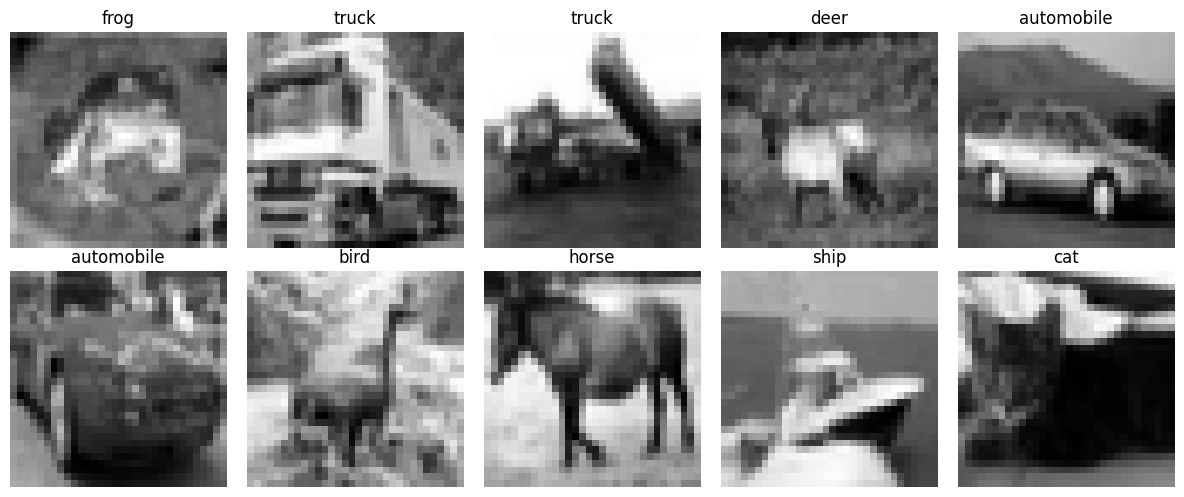

Input dimension: 1024 (flattened) = 1024
Training samples: 50000
Image shape: torch.Size([1, 32, 32])
Test samples: 10000


In [2]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Transform: convert to grayscale and binarize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
    #transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize at 0.5
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64  # Smaller batch size for larger images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'{class_names[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Input dimension: {32 * 32} (flattened) = 1024')

print(f'Training samples: {len(train_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Test samples: {len(test_dataset)}')

## 3. Implement Masked Linear Layer

The core of MADE is the `MaskedLinear` layer, which applies element-wise masks to weight matrices to ensure the autoregressive property.

In [3]:
class MaskedLinear(nn.Linear):
    """
    Linear layer with a configurable mask on the weights.
    The mask ensures that connections respect the autoregressive property.
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        """Set the mask for this layer."""
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.float32)))

    def forward(self, x):
        """Forward pass with masked weights."""
        return F.linear(x, self.weight * self.mask, self.bias)

## 4. Implement the MADE Model

The MADE model creates masks that enforce the autoregressive property:
- Each output dimension depends only on previous input dimensions
- Hidden units are assigned "degrees" that determine connectivity

In [4]:
class MADE(nn.Module):
    """
    Masked Autoencoder for Distribution Estimation.

    Args:
        input_dim: Dimension of input (1024 for grayscale CIFAR-10)
        hidden_dims: List of hidden layer dimensions
        natural_ordering: If True, use natural ordering (1,2,3,...), else random
    """
    def __init__(self, input_dim, hidden_dims, natural_ordering=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.natural_ordering = natural_ordering

        # Build network layers
        self.layers = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [input_dim*2]

        for i in range(len(dims) - 1):
            self.layers.append(MaskedLinear(dims[i], dims[i+1]))

        # Create masks
        self.create_masks()

    def create_masks(self):
        """
        Create masks for all layers to enforce autoregressive property.

        The key idea:
        - Assign each input dimension a number from 1 to D
        - Assign each hidden unit a number from 1 to D-1
        - A hidden unit with degree k can only connect to inputs with degree <= k
        - Output i can only connect to hidden units with degree < i
        """
        L = len(self.hidden_dims)

        # Assign degrees to each layer
        # m[l] contains the degrees for layer l
        self.m = {}

        # Input layer: degrees are 1, 2, ..., D (natural ordering) or permutation
        if self.natural_ordering:
            self.m[0] = np.arange(1, self.input_dim + 1)
        else:
            self.m[0] = np.random.permutation(np.arange(1, self.input_dim + 1))

        # Hidden layers: degrees are randomly sampled from 1 to D-1
        for l in range(1, L + 1):
            # Sample degrees between min(m[l-1]) and D-1
            self.m[l] = np.random.randint(
                self.m[l-1].min(),
                self.input_dim,
                size=self.hidden_dims[l-1]
            )

        # Output layer: same as input
        # self.m[L + 1] = self.m[0]
        self.m[L + 1] = np.tile(self.m[0], 2)  # Repeat for mean and log_std

        # Create masks based on degrees
        masks = []
        for l in range(len(self.layers)):
            if l < len(self.layers) - 1:
                # Hidden layer mask: m[l+1][i] >= m[l][j]
                mask = (self.m[l + 1][:, None] >= self.m[l][None, :]).astype(np.float32)
            else:
                # Output layer mask: m[l+1][i] > m[l][j] (strict inequality)
                mask = (self.m[l + 1][:, None] > self.m[l][None, :]).astype(np.float32)

            masks.append(mask)
            self.layers[l].set_mask(mask)

    def forward(self, x):
        """
        Forward pass through the network.
        Returns mean and log_std vectors(each with the same size as x) for normal distribution
        """
        # Flatten input if needed
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # Pass through layers with ReLU activations (except last layer)
        for i, layer in enumerate(self.layers[:-1]):
            x = F.relu(layer(x))

        # Last layer without activation (outputs logits)
        x = self.layers[-1](x)


        # Split into mean and log_std
        mean, log_std = x.chunk(2, dim=1)

        # Clamp log_std for numerical stability
        #log_std = torch.clamp(log_std, min=-7, max=7)

        return mean, log_std

    def sample(self, n_samples):
        """
        Generate samples using ancestral sampling.
        Sample each dimension sequentially conditioned on previous dimensions.
        """
        samples = torch.zeros(n_samples, self.input_dim).to(device)

        with torch.no_grad():
            for i in range(self.input_dim):
                # Forward pass to get distribution parameters
                mean, log_std = self.forward(samples)
                std = torch.exp(log_std)

                # Sample dimension i from Gaussian
                eps = torch.randn_like(mean[:, i])
                samples[:, i] = mean[:, i] + std[:, i] * eps

                # Clip to valid range [0, 1]
                samples[:, i] = torch.clamp(samples[:, i], 0, 1)

        return samples

## 5. Initialize the Model

In [5]:
# Model hyperparameters
input_dim = 32 * 32  # 1024 for grayscale CIFAR-10
hidden_dims = [2000]  # hidden layers with 512 units each

# Create model
model = MADE(input_dim, hidden_dims, natural_ordering=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(f'\nModel architecture:')
print(f'Input dimension: {input_dim}')

print(f'Hidden layers: {hidden_dims}')

Total parameters: 6,148,048

Model architecture:
Input dimension: 1024
Hidden layers: [2000]


In [6]:
model

MADE(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=1024, out_features=2000, bias=True)
    (1): MaskedLinear(in_features=2000, out_features=2048, bias=True)
  )
)

## 6. Define Loss Function and Optimizer

For binary CIFAR-10, we use binary cross-entropy loss (negative log-likelihood of Bernoulli distributions).

In [7]:
def gaussian_nll(mean, log_std, target):
    """
    Compute Gaussian negative log-likelihood.

    Args:
        mean: Predicted means (batch_size, input_dim)
        log_std: Predicted log standard deviations (batch_size, input_dim)
        target: Target data (batch_size, input_dim)

    Returns:
        Average negative log-likelihood per sample
    """
    std = torch.exp(log_std)

    # Gaussian NLL: 0.5 * log(2*pi) + log(std) + 0.5 * ((x - mean) / std)^2
    nll = 0.5 * np.log(2 * np.pi) + log_std + 0.5 * ((target - mean) / std) ** 2

    # Sum over dimensions, average over batch
    return nll.sum(dim=1).mean()

# Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Optimizer: Adam with learning rate {learning_rate}')

Optimizer: Adam with learning rate 0.0001


## 7. Training Loop

In [8]:
def train_epoch(model, train_loader, optimizer):
    """Train for one epoch."""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)

        optimizer.zero_grad()
        mean, log_std = model(data)
        loss = gaussian_nll(mean, log_std, data)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(train_loader)

def evaluate(model, test_loader):
    """Evaluate on test set."""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            mean, log_std = model(data)
            loss = gaussian_nll(mean, log_std, data)
            test_loss += loss.item()

    return test_loss / len(test_loader)

# Training
num_epochs = 30
train_losses = []
test_losses = []

print('Starting training...\n')

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer)
    test_loss = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

print('\nTraining complete')

Starting training...

Epoch  1/30 | Train Loss: -76.1417 | Test Loss: -327.1660
Epoch  2/30 | Train Loss: -457.6760 | Test Loss: -563.6018
Epoch  3/30 | Train Loss: -638.7306 | Test Loss: -689.3920
Epoch  4/30 | Train Loss: -734.2353 | Test Loss: -764.3066
Epoch  5/30 | Train Loss: -797.8285 | Test Loss: -816.5234
Epoch  6/30 | Train Loss: -847.3203 | Test Loss: -864.4744
Epoch  7/30 | Train Loss: -887.6653 | Test Loss: -897.1280
Epoch  8/30 | Train Loss: -921.2021 | Test Loss: -927.2437
Epoch  9/30 | Train Loss: -950.8453 | Test Loss: -953.8193
Epoch 10/30 | Train Loss: -976.6320 | Test Loss: -977.7721
Epoch 11/30 | Train Loss: -1000.0782 | Test Loss: -1003.4036
Epoch 12/30 | Train Loss: -1021.0030 | Test Loss: -1018.3078
Epoch 13/30 | Train Loss: -1040.3161 | Test Loss: -1036.9350
Epoch 14/30 | Train Loss: -1058.1552 | Test Loss: -1057.7676
Epoch 15/30 | Train Loss: -1074.9324 | Test Loss: -1071.2059
Epoch 16/30 | Train Loss: -1090.3001 | Test Loss: -1087.5453
Epoch 17/30 | Train Los

The negative values come from the fact that std tends to be closer to zero so log_std goes to -inf

##  Save Trained Model

Save the trained model checkpoint for later use.

In [22]:
# Save complete checkpoint
checkpoint_path = 'MADE_cifar_gaussian_checkpoint.ckpt'

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'input_dim': input_dim,
    'hidden_dims': hidden_dims,
    'learning_rate': learning_rate,
    'final_train_loss': train_losses[-1],
    'final_test_loss': test_losses[-1]
}, checkpoint_path)
print("model saved")

model saved


## 8. Visualize Training Progress

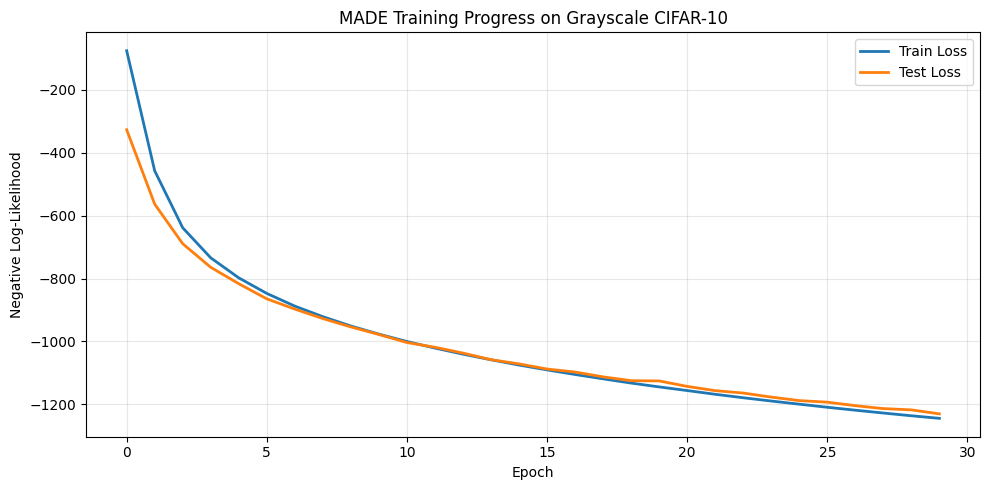

Final Train Loss: -1244.2369
Final Test Loss: -1229.9815


In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('MADE Training Progress on Grayscale CIFAR-10')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')

## 9. Generate Samples Using Ancestral Sampling

MADE can generate new CIFAR-10 images by sequentially sampling each pixel conditioned on previously sampled pixels.

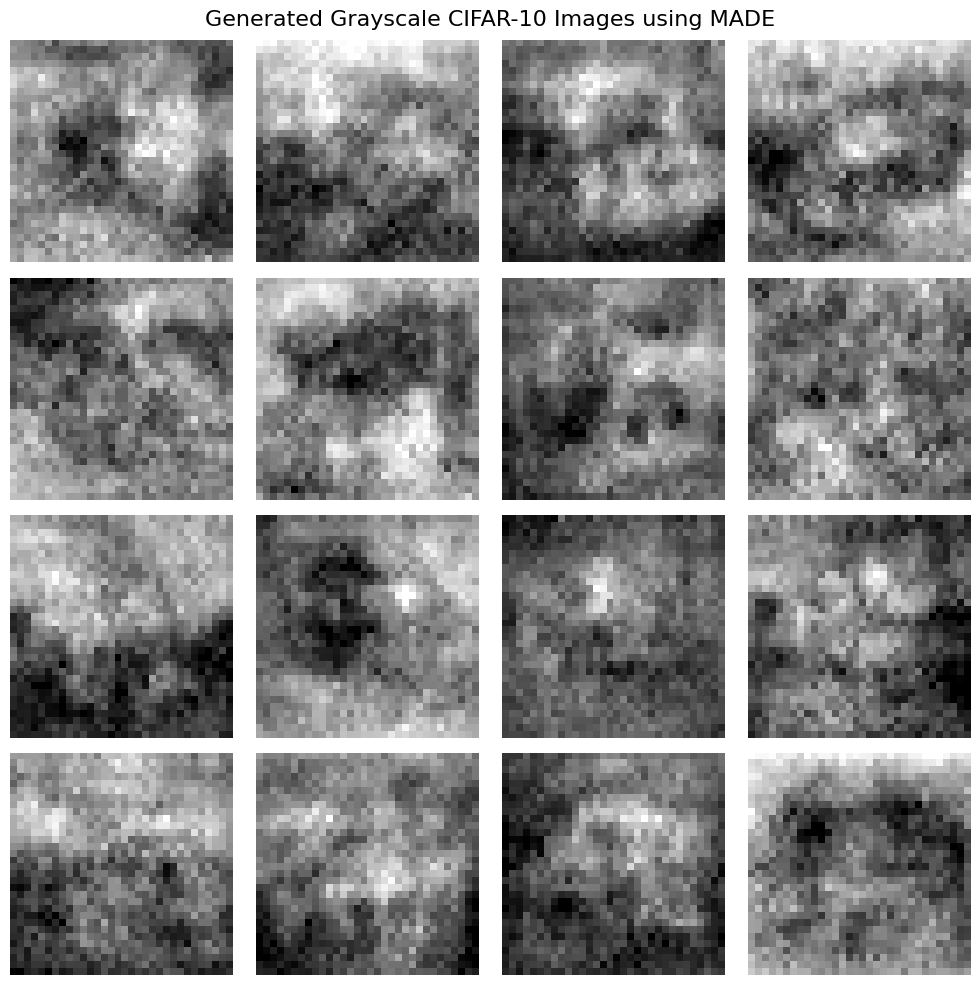

In [12]:
# Generate samples
model.eval()
n_samples = 16
samples = model.sample(n_samples)

# Reshape and visualize
samples = samples.cpu().numpy().reshape(-1, 32, 32)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Generated Grayscale CIFAR-10 Images using MADE', fontsize=16)
plt.tight_layout()
plt.show()

## 10. Evaluate Model - Log-Likelihood per Dimension

Calculate the average bits per dimension on the test set (a common metric for generative models).

In [ ]:
# # Calculate bits per dimension
# model.eval()
# total_nll = 0
# total_samples = 0

# with torch.no_grad():
#     for data, _ in test_loader:
#         data = data.view(data.size(0), -1).to(device)
#         logits = model(data)

#         # Binary cross entropy per pixel
#         nll = F.binary_cross_entropy_with_logits(logits, data, reduction='sum')
#         total_nll += nll.item()
#         total_samples += data.size(0)

# avg_nll_per_sample = total_nll / total_samples
# avg_nll_per_dim = avg_nll_per_sample / input_dim
# bits_per_dim = avg_nll_per_dim / np.log(2)  # Convert from nats to bits

# print(f'Test Set Evaluation:')
# print(f'  Average NLL per sample: {avg_nll_per_sample:.4f} nats')
# print(f'  Average NLL per dimension: {avg_nll_per_dim:.4f} nats')
# print(f'  Bits per dimension: {bits_per_dim:.4f} bits')
# print(f'\nNote: Lower values indicate better density estimation.')

In [13]:
# Calculate bits per dimension
model.eval()
total_nll = 0
total_samples = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(data.size(0), -1).to(device)
        mean, log_std = model(data)

        # Gaussian NLL
        std = torch.exp(log_std)
        nll = 0.5 * np.log(2 * np.pi) + log_std + 0.5 * ((data - mean) / std) ** 2

        total_nll += nll.sum().item()
        total_samples += data.size(0)

avg_nll_per_sample = total_nll / total_samples
avg_nll_per_dim = avg_nll_per_sample / input_dim
bits_per_dim = avg_nll_per_dim / np.log(2)  # Convert from nats to bits

print(f'Test Set Evaluation:')
print(f'  Average NLL per sample: {avg_nll_per_sample:.4f} nats')
print(f'  Average NLL per dimension: {avg_nll_per_dim:.4f} nats')
print(f'  Bits per dimension: {bits_per_dim:.4f} bits')
print(f'\nNote: Lower values indicate better density estimation.')
print(f'For reference, good autoregressive models achieve ~3-4 bits/dim on CIFAR-10.')

Test Set Evaluation:
  Average NLL per sample: -1230.4527 nats
  Average NLL per dimension: -1.2016 nats
  Bits per dimension: -1.7336 bits

Note: Lower values indicate better density estimation.
For reference, good autoregressive models achieve ~3-4 bits/dim on CIFAR-10.


## 11. Visualize Learned Conditional Distributions

We can visualize what the model has learned by fixing all but one pixel and showing the predicted probability for that pixel.

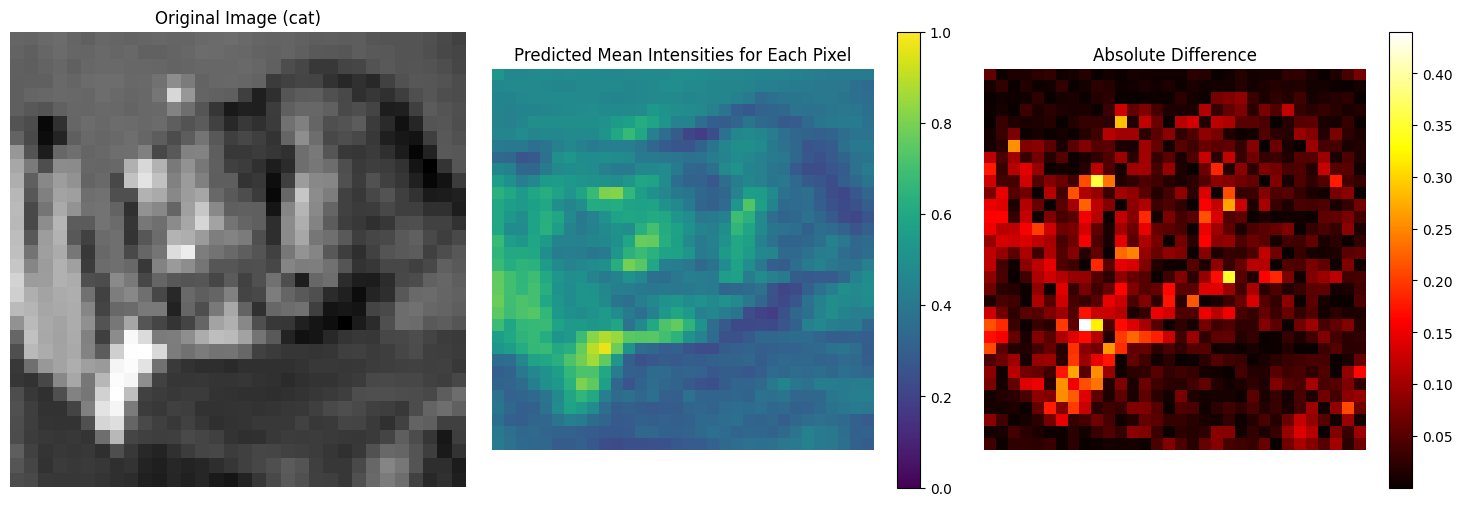

Average predicted mean on original active pixels: 0.5920
Average predicted mean on original inactive pixels: 0.3862


In [14]:
# Take a test image and visualize conditional probabilities
model.eval()
test_img, test_label = test_dataset[0]
test_img_flat = test_img.view(1, -1).to(device)

with torch.no_grad():
    # Unpack mean and log_std from the model's output
    mean, log_std = model(test_img_flat)

# For visualization, use the mean as the predicted pixel intensity
# Clamp to [0, 1] range as pixel values are typically between 0 and 1
probs_img = mean.cpu().numpy().reshape(32, 32)
probs_img = np.clip(probs_img, 0, 1)

test_img_show = test_img.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(test_img_show, cmap='gray')
axes[0].set_title(f'Original Image ({class_names[test_label]})')
axes[0].axis('off')

# Predicted probabilities (now showing mean intensities)
im = axes[1].imshow(probs_img, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title('Predicted Mean Intensities for Each Pixel')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

# Difference
diff = np.abs(test_img_show - probs_img)
im2 = axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Absolute Difference')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# These print statements are more relevant for binary outputs. For Gaussian outputs
# it's generally more common to look at reconstruction quality (original vs mean)
# or other metrics. However, if treating mean as probability, you can keep them.
# You might need to adjust the condition if your `test_img_show` is not strictly 0 or 1
print(f'Average predicted mean on original active pixels: {probs_img[test_img_show > 0.5].mean():.4f}')
print(f'Average predicted mean on original inactive pixels: {probs_img[test_img_show <= 0.5].mean():.4f}')

## 11. Visualize Reconstruction Quality

Compare original test images with the model's predicted means to see how well it captures the data.

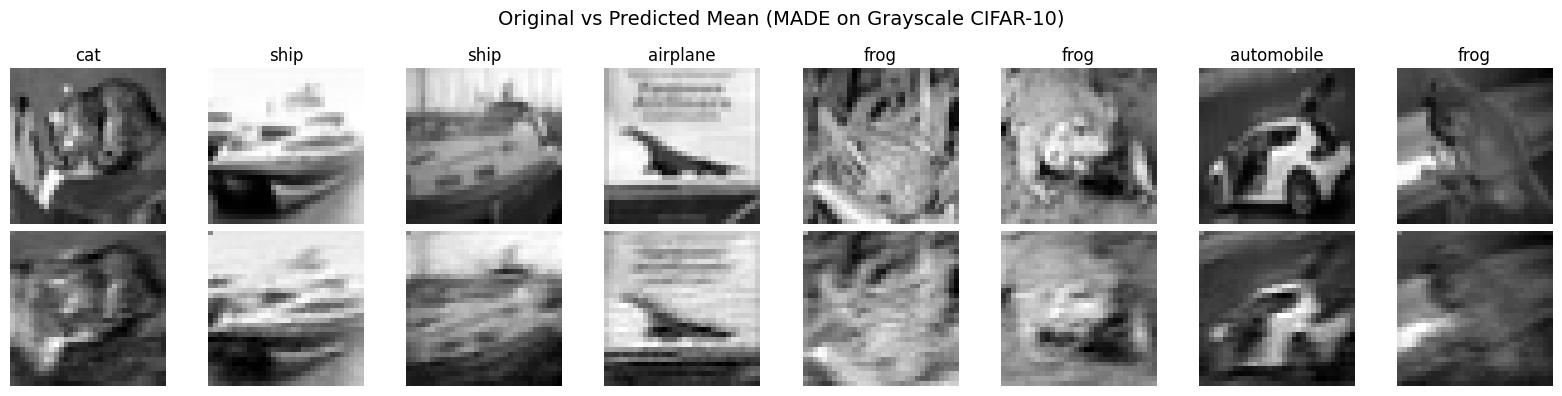

In [15]:
# Take some test images and compare with predictions
model.eval()
n_compare = 8

# Get a batch of test images
test_images = []
test_labels = []
for i in range(n_compare):
    img, label = test_dataset[i]
    test_images.append(img)
    test_labels.append(label)

test_images = torch.stack(test_images).to(device)
test_images_flat = test_images.view(n_compare, -1)

with torch.no_grad():
    mean, log_std = model(test_images_flat)

# Reshape predictions
mean_images = mean.cpu().numpy().reshape(n_compare, 32, 32)
mean_images = np.clip(mean_images, 0, 1)

# Original images
orig_images = test_images.cpu().numpy().squeeze(1)  # Remove channel dimension

# Plot comparisons
fig, axes = plt.subplots(2, n_compare, figsize=(16, 4))

for i in range(n_compare):
    # Original
    axes[0, i].imshow(orig_images[i], cmap='gray')
    axes[0, i].set_title(f'{class_names[test_labels[i]]}')
    axes[0, i].axis('off')

    # Predicted mean
    axes[1, i].imshow(mean_images[i], cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Predicted\nMean', fontsize=12)

plt.suptitle('Original vs Predicted Mean (MADE on Grayscale CIFAR-10)', fontsize=14)
plt.tight_layout()
plt.show()

## 12. Conditional Image Completion

Demonstrate the autoregressive property by conditioning on partial images and completing them.

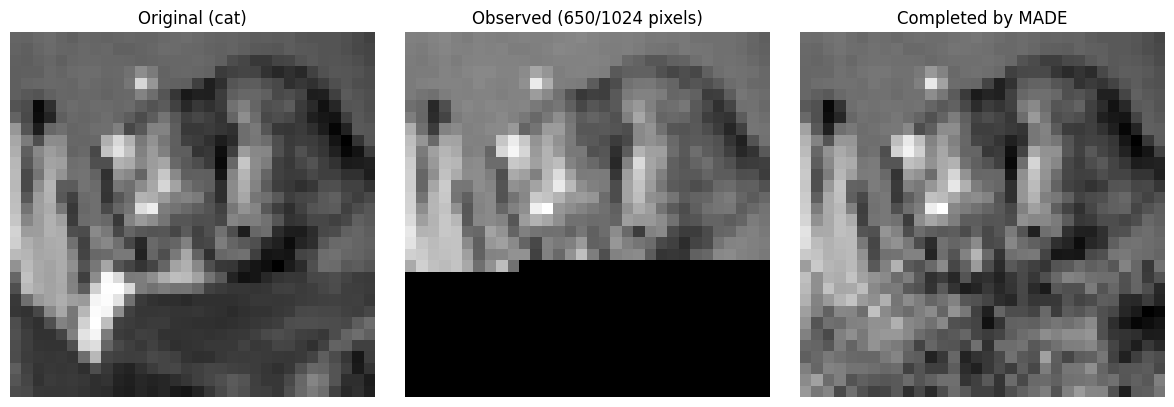

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


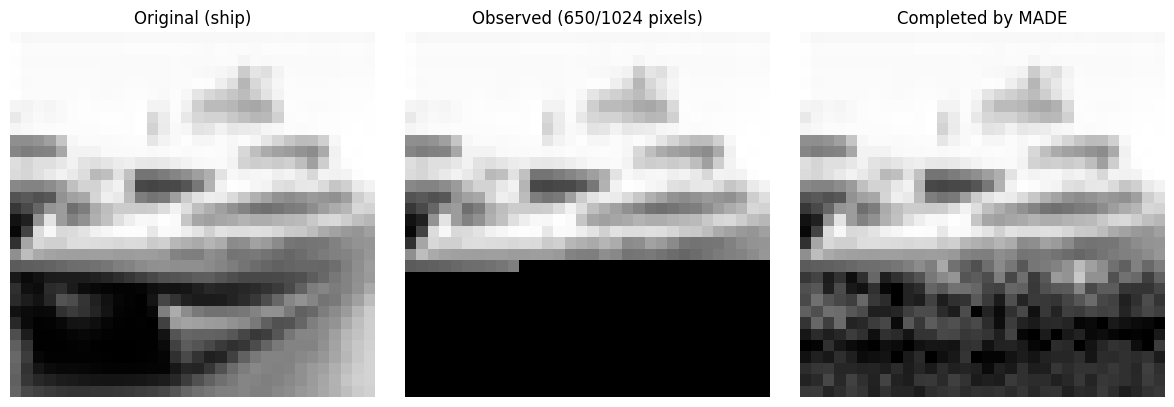

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


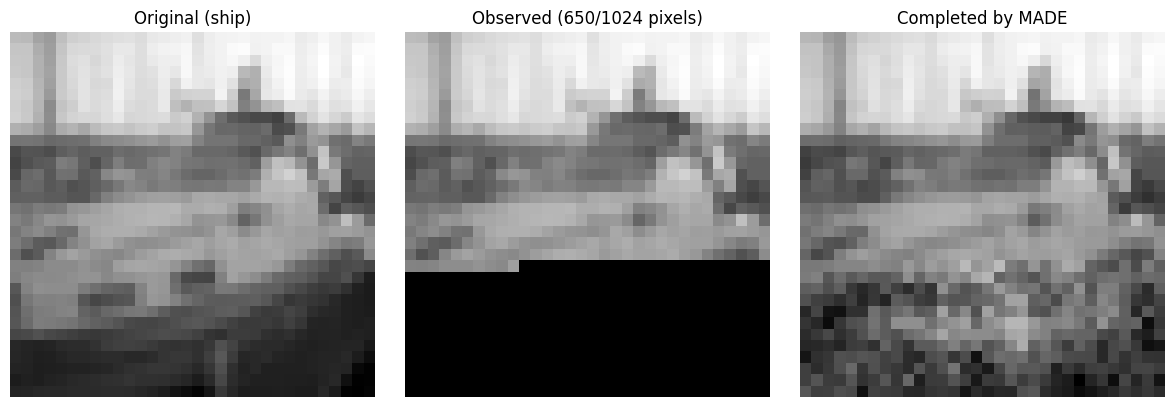

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


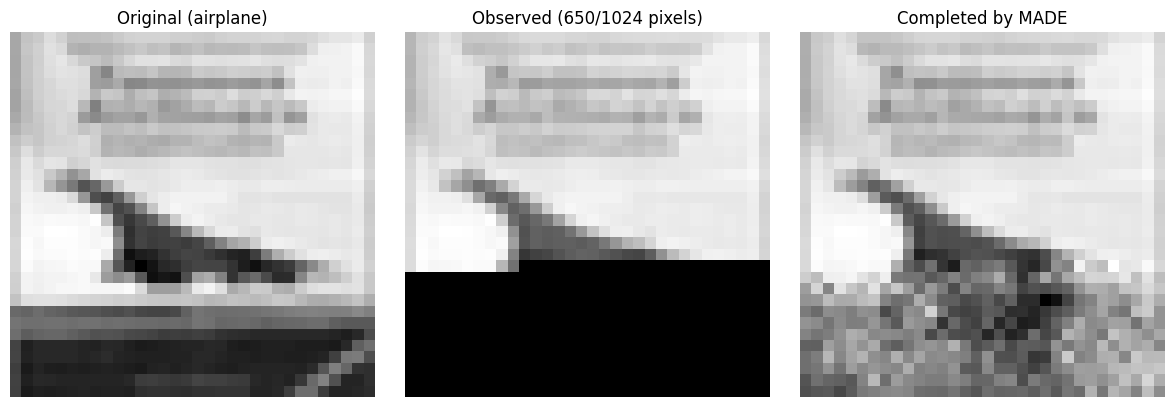

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


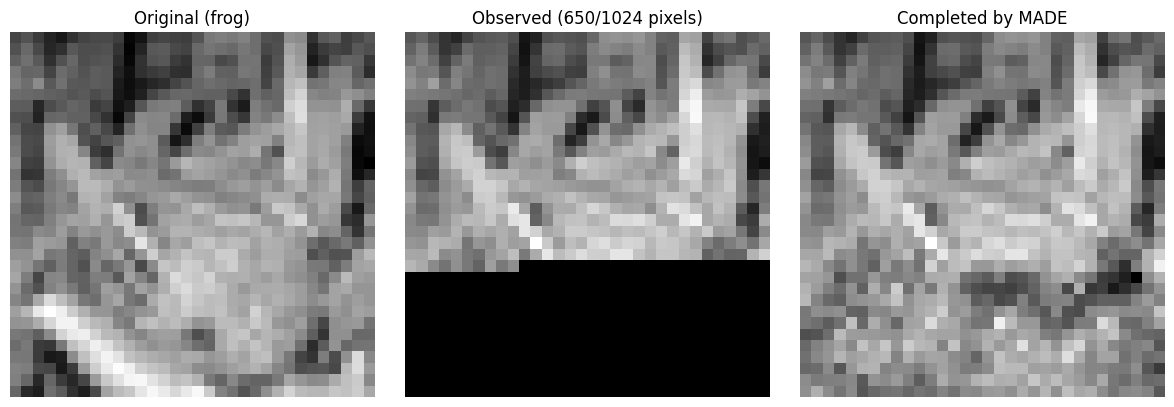

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


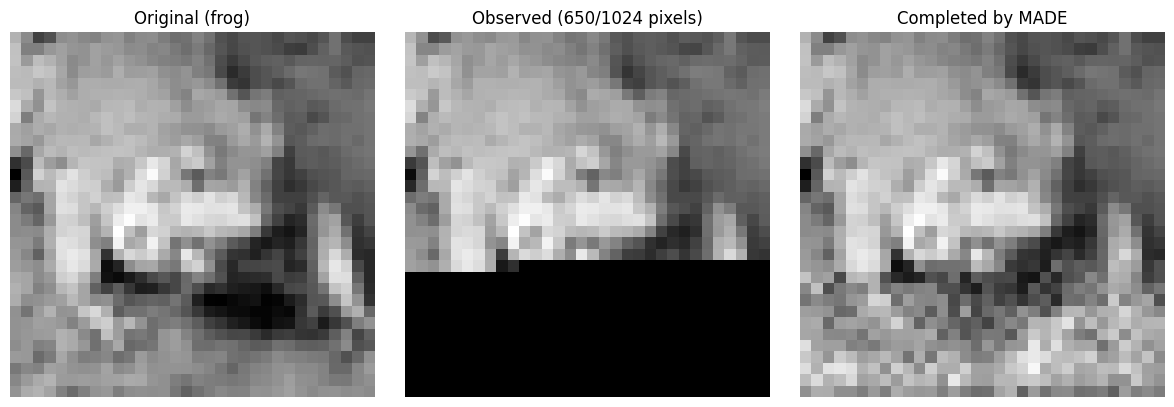

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


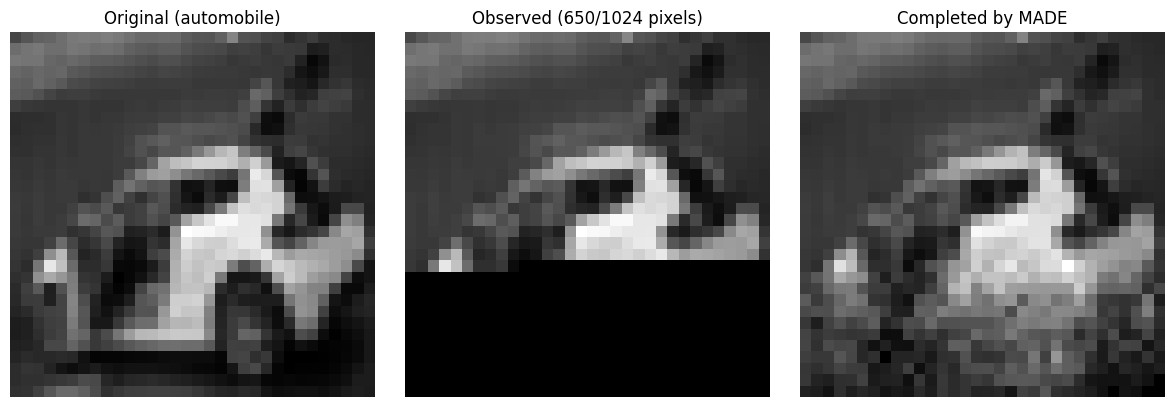

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


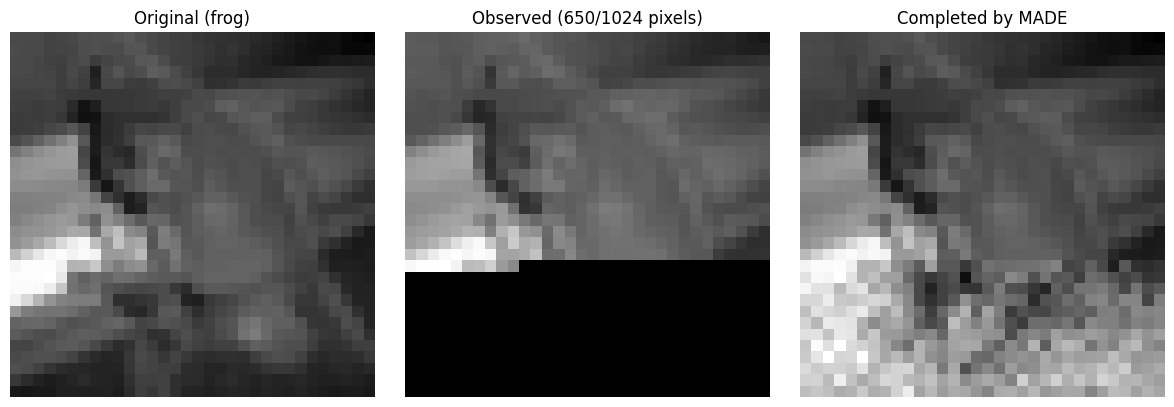

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


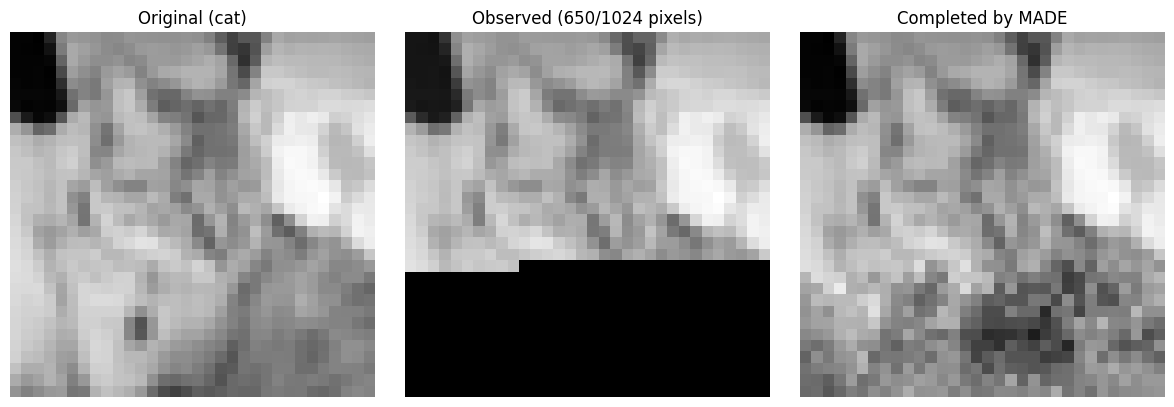

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


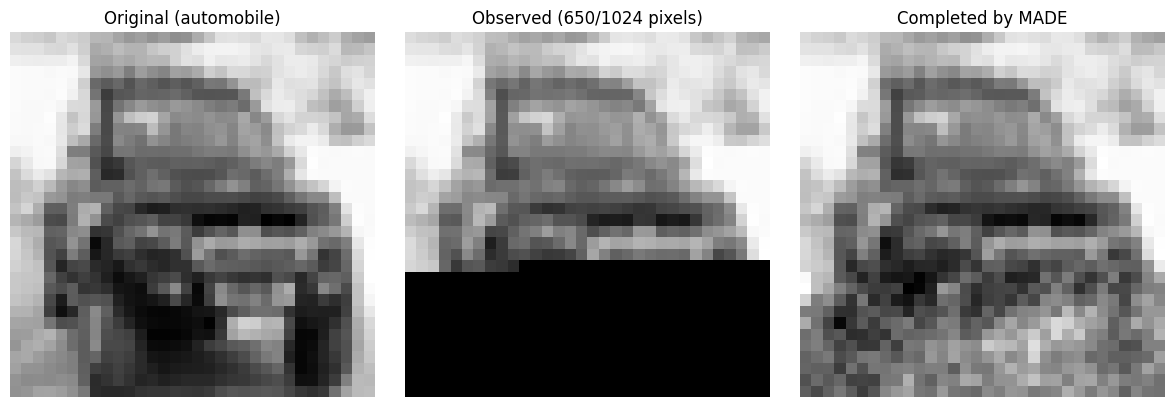

Completed image by sampling 374 pixels conditioned on 650 observed pixels.


In [18]:
# Conditional completion: give the model the left half, generate the right half
model.eval()
for i in range(10):
  test_img, test_label = test_dataset[i]
  test_img_flat = test_img.view(1, -1).to(device)

  # Create a partial image (left half known, right half to be generated)
  # Each row has 32 pixels, and we have 32 rows, 1 channel (grayscale)
  # Total ordering: pixels in natural order
  # For simplicity, let's condition on the first 50% of dimensions

  partial_img = torch.zeros_like(test_img_flat)
  #n_observed = input_dim // 2
  n_observed = 650

  # Copy observed pixels from original image
  partial_img[:, :n_observed] = test_img_flat[:, :n_observed]

  # Sequentially sample the rest
  with torch.no_grad():
      for i in range(n_observed, input_dim):
          mean, log_std = model(partial_img)
          std = torch.exp(log_std)

          # Sample pixel i
          eps = torch.randn(1).to(device)
          partial_img[:, i] = mean[:, i] + std[:, i] * eps
          partial_img[:, i] = torch.clamp(partial_img[:, i], 0, 1)

  # Reshape for visualization
  original = test_img.squeeze(0).cpu().numpy()  # Remove channel dimension
  completed = partial_img.cpu().numpy().reshape(32, 32)
  completed = np.clip(completed, 0, 1)

  # Create a mask showing what was observed
  mask_flat = np.zeros(32 * 32)
  mask_flat[:n_observed] = 1.0

  # Reshape to (32, 32)
  mask = mask_flat.reshape(32, 32)
  observed = original * mask


  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(original, cmap='gray')
  axes[0].set_title(f'Original ({class_names[test_label]})')
  axes[0].axis('off')

  axes[1].imshow(observed, cmap='gray')
  axes[1].set_title(f'Observed ({n_observed}/{input_dim} pixels)')
  axes[1].axis('off')

  axes[2].imshow(completed, cmap='gray')
  axes[2].set_title('Completed by MADE')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

  print(f'Completed image by sampling {input_dim - n_observed} pixels conditioned on {n_observed} observed pixels.')

## 13. Calculate FID Score

Fréchet Inception Distance (FID) measures the quality of generated images by comparing their statistics to real images using an Inception network.

In [19]:
from scipy import linalg
from torchvision.models import inception_v3

def get_inception_model():
    """Load pretrained InceptionV3 model for FID calculation."""
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove final classification layer
    inception.eval()
    return inception.to(device)

def preprocess_for_inception(images):
    """
    Preprocess images for Inception network.

    Args:
        images: Tensor of shape (N, 1, 32, 32) in [0, 1] range (grayscale)

    Returns:
        Tensor of shape (N, 3, 299, 299) suitable for InceptionV3
    """
    # Convert grayscale to RGB by repeating channels
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)

    # Resize to 299x299 (Inception input size)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # Normalize to [-1, 1] range (Inception expects this)
    images = (images - 0.5) / 0.5

    return images

def get_inception_features(images, inception_model, batch_size=32):
    """
    Extract features from images using InceptionV3.

    Args:
        images: Tensor of shape (N, 1, H, W) or (N, 3, H, W)
        inception_model: Pretrained InceptionV3 model
        batch_size: Batch size for processing

    Returns:
        Features of shape (N, 2048)
    """
    inception_model.eval()
    features_list = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch = preprocess_for_inception(batch).to(device)

            # Get features
            features = inception_model(batch)
            features_list.append(features.cpu())

    return torch.cat(features_list, dim=0).numpy()

def calculate_fid(real_features, fake_features):
    """
    Calculate Fréchet Inception Distance between real and generated images.

    Args:
        real_features: Features from real images (N, 2048)
        fake_features: Features from generated images (M, 2048)

    Returns:
        FID score (float)
    """
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)

    return float(fid)

print("FID calculation functions defined successfully!")
print("Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)")

FID calculation functions defined successfully!
Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)


In [20]:
# Load Inception model
print("Loading InceptionV3 model...")
inception_model = get_inception_model()
print("InceptionV3 loaded successfully!")

# Generate samples for FID calculation
print("\nGenerating samples for FID calculation...")
n_fid_samples = 5000  # Use 5000 samples for reliable FID estimate
model.eval()

# Generate in batches to avoid memory issues
batch_size_gen = 500
all_generated_samples = []

for i in range(0, n_fid_samples, batch_size_gen):
    batch_size_current = min(batch_size_gen, n_fid_samples - i)
    samples_batch = model.sample(batch_size_current)
    # Reshape to (N, 1, 32, 32)
    samples_batch = samples_batch.view(batch_size_current, 1, 32, 32)
    all_generated_samples.append(samples_batch)
    print(f"Generated {i + batch_size_current}/{n_fid_samples} samples")

generated_samples = torch.cat(all_generated_samples, dim=0)
print(f"Generated samples shape: {generated_samples.shape}")

# Get real images from test set
print("\nExtracting real images from test set...")
real_images_list = []
for i in range(n_fid_samples):
    img, _ = test_dataset[i % len(test_dataset)]
    real_images_list.append(img)

real_images = torch.stack(real_images_list)
print(f"Real images shape: {real_images.shape}")

# Extract features
print("\nExtracting features from real images...")
real_features = get_inception_features(real_images, inception_model, batch_size=32)
print(f"Real features shape: {real_features.shape}")

print("\nExtracting features from generated images...")
fake_features = get_inception_features(generated_samples, inception_model, batch_size=32)
print(f"Generated features shape: {fake_features.shape}")

# Calculate FID
print("\nCalculating FID score...")
fid_score = calculate_fid(real_features, fake_features)

print(f"\n{'='*50}")
print(f"FID Score: {fid_score:.2f}")
print(f"{'='*50}")
print("\nNote: Lower FID scores indicate better quality generated images.")
print("Typical FID ranges:")
print("  - FID < 50: Good quality")
print("  - FID 50-100: Moderate quality")
print("  - FID > 100: Poor quality")

Loading InceptionV3 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 216MB/s] 


InceptionV3 loaded successfully!

Generating samples for FID calculation...
Generated 500/5000 samples
Generated 1000/5000 samples
Generated 1500/5000 samples
Generated 2000/5000 samples
Generated 2500/5000 samples
Generated 3000/5000 samples
Generated 3500/5000 samples
Generated 4000/5000 samples
Generated 4500/5000 samples
Generated 5000/5000 samples
Generated samples shape: torch.Size([5000, 1, 32, 32])

Extracting real images from test set...
Real images shape: torch.Size([5000, 1, 32, 32])

Extracting features from real images...
Real features shape: (5000, 2048)

Extracting features from generated images...
Generated features shape: (5000, 2048)

Calculating FID score...


/tmp/ipython-input-2819272317.py:81: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)



FID Score: 261.55

Note: Lower FID scores indicate better quality generated images.
Typical FID ranges:
  - FID < 50: Good quality
  - FID 50-100: Moderate quality
  - FID > 100: Poor quality


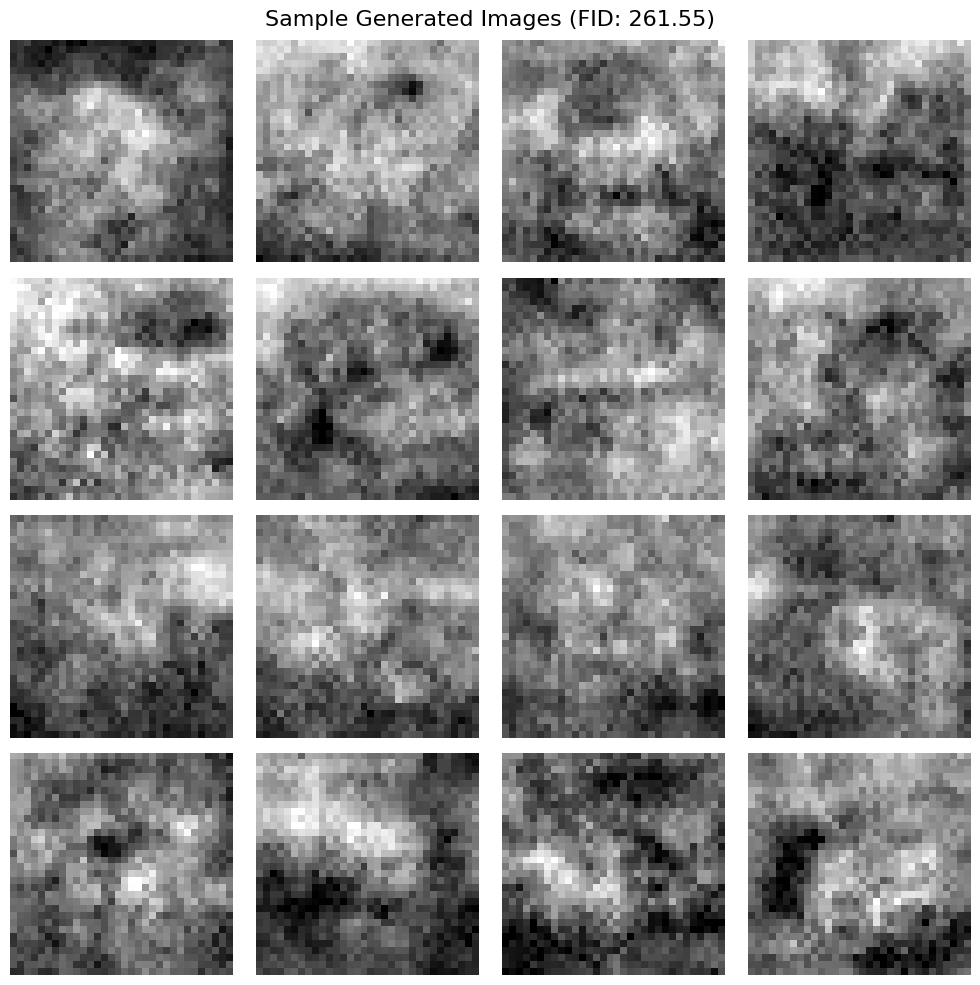

In [21]:
# Visualize some generated samples used for FID
n_vis = 16
vis_samples = generated_samples[:n_vis].cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(vis_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle(f'Sample Generated Images (FID: {fid_score:.2f})', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

This notebook implemented **MADE (Masked Autoencoder for Distribution Estimation)** on grayscale CIFAR-10, a powerful autoregressive generative model. Key highlights:

1. **Masked Connections**: Used masked weight matrices to enforce autoregressive dependencies
2. **Efficient Training**: Unlike traditional autoregressive models, MADE computes all conditional probabilities in a single forward pass
3. **Ancestral Sampling**: Generated new samples by sequentially sampling pixels conditioned on previous ones
4. **Binary CIFAR-10**: Trained on binarized grayscale CIFAR-10 images (32×32) using negative log-likelihood loss

The model learns to capture the joint distribution $p(x_1, x_2, ..., x_{1024})$ by factorizing it as:
$$p(x) = \prod_{i=1}^{1024} p(x_i | x_{<i})$$

This architecture forms the basis for more advanced models like PixelCNN and autoregressive normalizing flows!